In [16]:
# Cell 1 - Imports and configuration
import os
from typing import Optional, Tuple

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration: change paths if your project structure differs
DATA_PATH = "../data/processed/df_normalized.csv"
CHECKPOINT_PATH = "../models/checkpoints/best_model.pth"
SAVED_MODEL_DIR = "../models/saved_models/lstm_model"
SCALER_PATH = "../models/saved_models/scaler.pkl"  # common place to store scaler; may not exist
LOOKBACK = 60  # must match training lookback
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPS = 1e-8  # small epsilon to avoid division by zero in MAPE


In [17]:
# Cell 2 - Build sequences and return matching timestamps for y values
def create_sequences_with_timestamps(series: pd.Series, lookback: int = 60) -> Tuple[np.ndarray, np.ndarray, pd.Index]:
    """
    Create input sequences and targets from a pandas Series and
    return the timestamps (index) corresponding to each target (y).

    The returned timestamps correspond to series.index[lookback:].
    """
    values = series.values.astype(float)
    X, y = [], []
    timestamps = []

    for i in range(lookback, len(values)):
        X.append(values[i - lookback : i])
        y.append(values[i])
        timestamps.append(series.index[i])

    X = np.array(X).reshape(-1, lookback, 1)  # (samples, lookback, features=1)
    y = np.array(y).reshape(-1, 1)
    timestamps = pd.DatetimeIndex(timestamps)

    return X, y, timestamps


# Load dataframe and create sequences
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
if "Close" not in df.columns:
    raise KeyError("Expected column 'Close' in the CSV.")
series_close = df["Close"]

X_all, y_all, timestamps_all = create_sequences_with_timestamps(
    series_close, lookback=LOOKBACK
)

# Re-create the temporal train/val/test split indices used in the script
def temporal_train_val_test_split(
    n_samples: int, train_ratio: float = 0.7, val_ratio: float = 0.15
) -> Tuple[slice, slice, slice]:
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * val_ratio)
    train_slice = slice(0, train_size)
    val_slice = slice(train_size, train_size + val_size)
    test_slice = slice(train_size + val_size, n_samples)
    return train_slice, val_slice, test_slice


train_slice, val_slice, test_slice = temporal_train_val_test_split(
    len(X_all)
)

X_test = X_all[test_slice]
y_test = y_all[test_slice]
timestamps_test = timestamps_all[test_slice]

print(f"Total sequences: {len(X_all)}")
print(f"Test samples: {len(X_test)}")


Total sequences: 6413
Test samples: 963


C:\Users\igor-\AppData\Local\Temp\ipykernel_14388\2626150176.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)


In [18]:
# Cell 3 - SIMPLE model + scaler loader (adds parent dir to sys.path then imports)
import os
import sys
from importlib import import_module
from typing import Dict, Tuple

import joblib
import pandas as pd
import torch

# Ensure parent directory is in sys.path so "src" package becomes importable.
# This is the minimal change you asked for: go up one level (..).
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

def load_model_and_scaler(
    checkpoint_path: str,
    saved_model_dir: str,
    scaler_path: str,
    device: torch.device,
    default_params: Dict,
) -> Tuple[torch.nn.Module, object]:
    """
    Try to import LSTMModel from src.models.lstm_model (assuming project root is parent dir),
    instantiate it using metadata.json (if present) or default_params, load checkpoint if found,
    and attempt to load a scaler with joblib. Returns (model, scaler_or_none).
    """
    # Import model definition (expects src to be importable after adding parent_dir)
    module = import_module("src.models.lstm_model")
    LSTMModel = getattr(module, "LSTMModel")

    # Read metadata.json if present to update model params
    metadata_path = os.path.join(saved_model_dir, "metadata.json")
    model_params = default_params.copy()
    if os.path.exists(metadata_path):
        try:
            meta = pd.read_json(metadata_path, typ="series").to_dict()
        except Exception:
            try:
                import json
                with open(metadata_path, "r") as fh:  # noqa: SIM110
                    meta = json.load(fh)
            except Exception:
                meta = {}
        for k in ("input_size", "hidden_size", "num_layers", "output_size", "dropout"):
            if k in meta:
                model_params[k] = meta[k]

    # Instantiate the model
    model = LSTMModel(
        input_size=model_params.get("input_size", 1),
        hidden_size=model_params.get("hidden_size", 50),
        num_layers=model_params.get("num_layers", 2),
        output_size=model_params.get("output_size", 1),
        dropout=model_params.get("dropout", 0.0),
    )

    # Load weights if available
    if os.path.exists(checkpoint_path):
        state = torch.load(checkpoint_path, map_location=device)
        if isinstance(state, dict) and "model_state_dict" in state:
            model.load_state_dict(state["model_state_dict"])
        elif isinstance(state, dict) and "state_dict" in state:
            model.load_state_dict(state["state_dict"])
        else:
            model.load_state_dict(state)
        print(f"✓ Loaded checkpoint from: {checkpoint_path}")
    else:
        print(f"⚠️ Checkpoint not found at {checkpoint_path}. Model will be uninitialized.")

    model.to(device)
    model.eval()

    # Load scaler if present
    scaler = None
    if os.path.exists(scaler_path):
        try:
            scaler = joblib.load(scaler_path)
            print(f"✓ Loaded scaler from: {scaler_path}")
        except Exception as exc:
            print(f"⚠️ Failed to load scaler: {exc}. Continuing without scaler.")
    else:
        print("⚠️ Scaler file not found. Metrics will be computed on the scaled values unless you inverse-transform manually.")

    return model, scaler


# Default params in case metadata not found; keep consistent with training defaults
DEFAULT_MODEL_PARAMS = {
    "input_size": 1,
    "hidden_size": 50,
    "num_layers": 2,
    "output_size": 1,
    "dropout": 0.2,
}

model, scaler = load_model_and_scaler(
    checkpoint_path=CHECKPOINT_PATH,
    saved_model_dir=SAVED_MODEL_DIR,
    scaler_path=SCALER_PATH,
    device=DEVICE,
    default_params=DEFAULT_MODEL_PARAMS,
)


✓ Loaded checkpoint from: ../models/checkpoints/best_model.pth
✓ Loaded scaler from: ../models/saved_models/scaler.pkl


In [19]:
# Cell 4 - Batch prediction utility and optional inverse transform
import math


def predict_numpy(
    model: torch.nn.Module,
    X: np.ndarray,
    device: torch.device,
    batch_size: int = 256,
) -> np.ndarray:
    """
    Predict on numpy X shaped (n_samples, lookback, features).
    Returns predictions shaped (n_samples, 1) as numpy array.
    """
    model.to(device)
    model.eval()
    preds = []

    n_samples = X.shape[0]
    with torch.no_grad():
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch = torch.from_numpy(X[start:end]).float().to(device)
            out = model(batch)  # model expected to return (batch, output_size)
            if isinstance(out, tuple) or isinstance(out, list):
                out = out[0]
            preds.append(out.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    return preds.reshape(-1, 1)


def inverse_transform_if_possible(
    arr: np.ndarray, scaler, feature_index: int = 0
) -> np.ndarray:
    """
    Try to inverse transform a 2D array using scaler.
    Accepts scalers that implement inverse_transform on 2D arrays
    or scalers that transform a single feature (we try to reshape accordingly).
    If scaler is None or fails, return original array.
    """
    if scaler is None:
        return arr
    try:
        # If arr has shape (n, 1), pass it directly
        if arr.ndim == 2 and arr.shape[1] == 1:
            inv = scaler.inverse_transform(arr)
            return inv
        # Otherwise try to expand to match scaler's expected shape and inverse
        elif arr.ndim == 1:
            inv = scaler.inverse_transform(arr.reshape(-1, 1))
            return inv
        else:
            # fallback: attempt direct inverse
            inv = scaler.inverse_transform(arr)
            return inv
    except Exception:
        # Some people save scaler for multi-feature data; we try to reconstruct
        try:
            n = arr.shape[0]
            fake = np.zeros((n, getattr(scaler, "n_features_in_", arr.shape[1])))
            fake[:, feature_index] = arr.ravel()
            inv = scaler.inverse_transform(fake)[:, feature_index].reshape(-1, 1)
            return inv
        except Exception:
            # if all fails, return original
            print("⚠️ scaler.inverse_transform failed; returning original array (scaled).")
            return arr


# Run prediction
y_pred_scaled = predict_numpy(model, X_test, device=DEVICE, batch_size=256)
y_true_scaled = y_test  # still scaled if scaler used in preprocessing

# Try to inverse transform both predicted and true values to original scale
y_pred = inverse_transform_if_possible(y_pred_scaled, scaler)
y_true = inverse_transform_if_possible(y_true_scaled, scaler)

print(f"Predictions shape: {y_pred.shape}")
print(f"Ground-truth shape: {y_true.shape}")


Predictions shape: (963, 1)
Ground-truth shape: (963, 1)


In [20]:
# Cell 5 - Compute metrics and save to CSV / print nicely
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Compute MAE, RMSE, and MAPE.
    y_true and y_pred are expected to be 2D arrays shaped (n, 1) or 1D arrays.
    """
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()

    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = math.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    # MAPE: handle zeros by clipping true values to EPS
    denom = np.clip(np.abs(y_true_flat), EPS, None)
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / denom)) * 100.0

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


metrics = compute_metrics(y_true, y_pred)

# Pretty print
print("FINAL METRICS ON TEST SET")
print("-------------------------")
print(f"MAE : {metrics['MAE']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6f}")
print(f"MAPE: {metrics['MAPE']:.4f}%")

# Save metrics to CSV
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
metrics_df = pd.DataFrame([metrics])
metrics_df["timestamp"] = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
metrics_csv_path = os.path.join(results_dir, "final_test_metrics.csv")

if os.path.exists(metrics_csv_path):
    existing = pd.read_csv(metrics_csv_path)
    combined = pd.concat([existing, metrics_df], ignore_index=True)
    combined.to_csv(metrics_csv_path, index=False)
else:
    metrics_df.to_csv(metrics_csv_path, index=False)

print(f"✓ Metrics saved to: {metrics_csv_path}")


FINAL METRICS ON TEST SET
-------------------------
MAE : 1.916363
RMSE: 2.430131
MAPE: 6.7975%
✓ Metrics saved to: results\final_test_metrics.csv


✓ Saved plot: results/real_vs_predicted.png


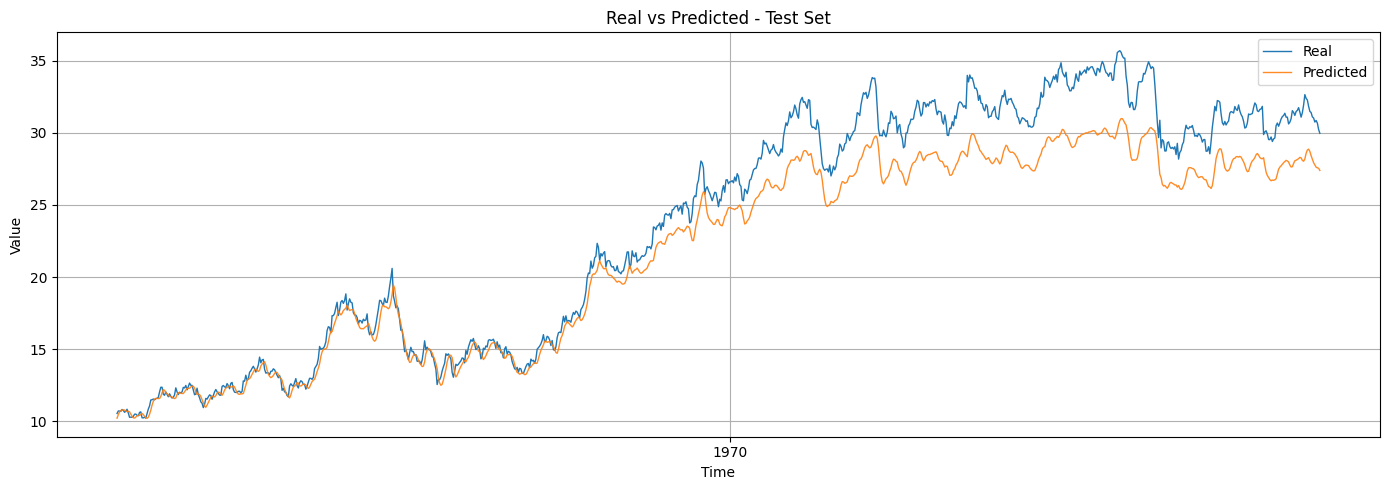

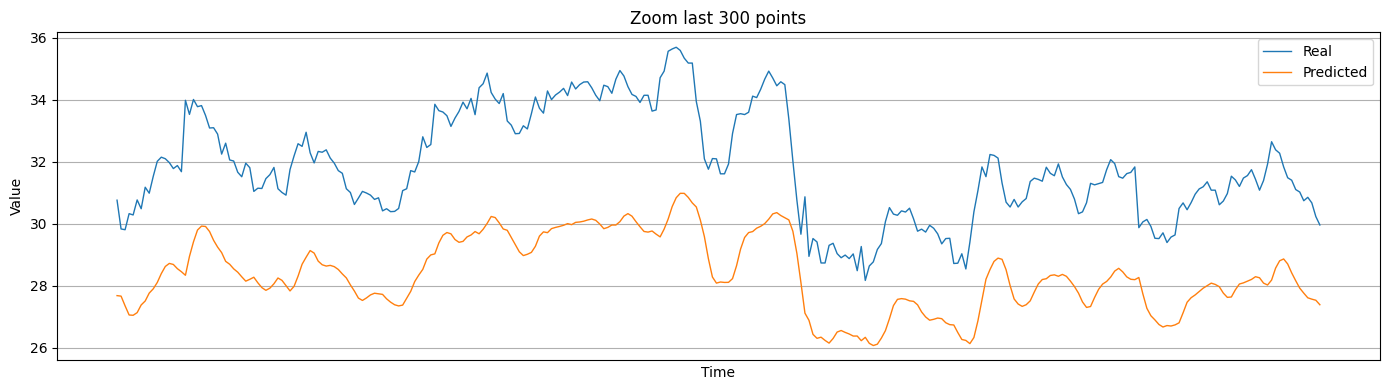

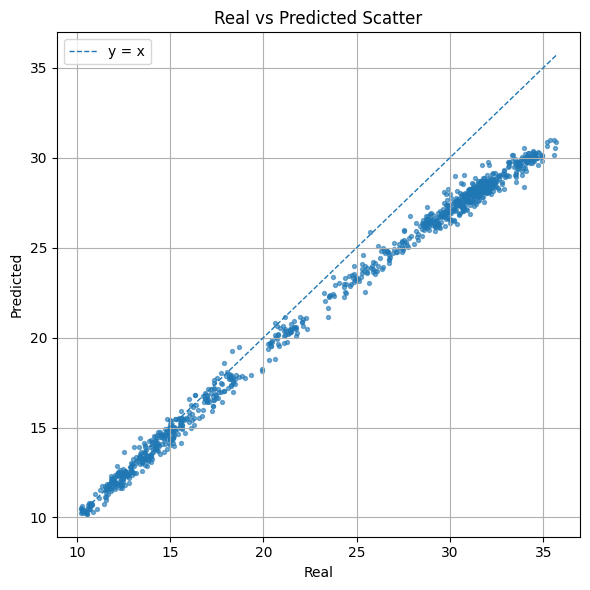

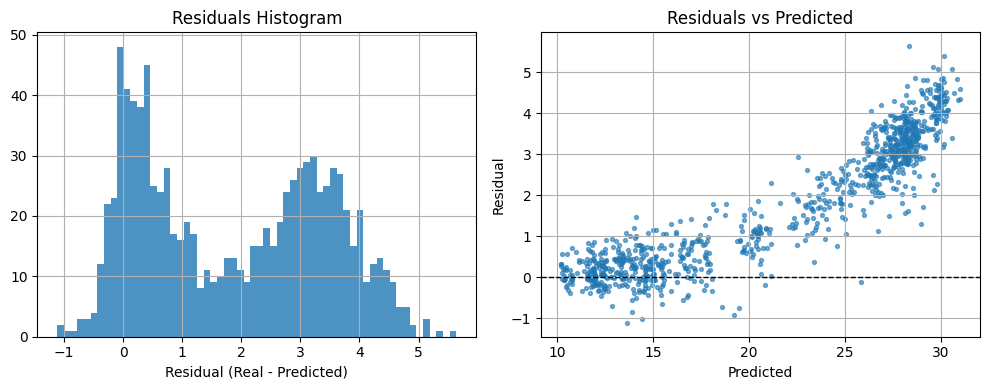

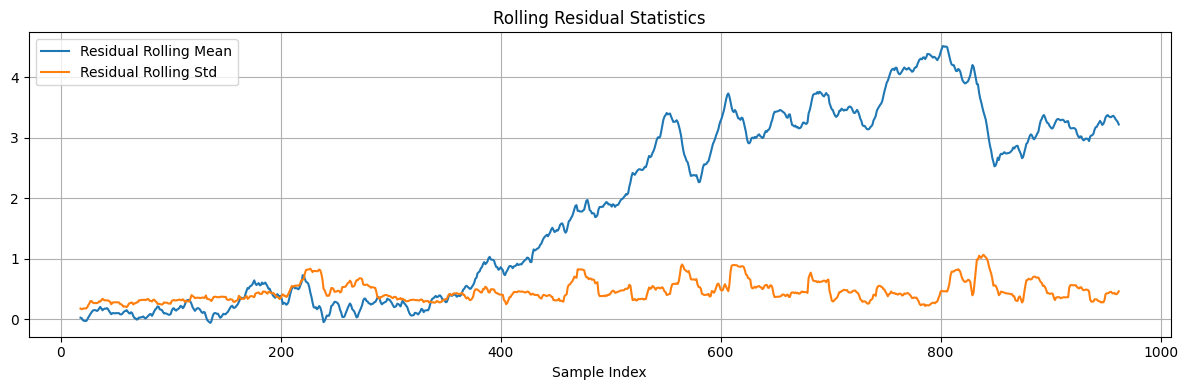

In [21]:
# Cell 6 - Visualization: Real vs Predicted, Scatter, Residuals analysis
def plot_real_vs_predicted(
    timestamps: pd.DatetimeIndex,
    y_true: np.ndarray,
    y_pred: np.ndarray,
    save_path: Optional[str] = None,
    zoom_last: Optional[int] = 300,
):
    """
    Plot series real vs predicted over time.
    Optionally zoom on last `zoom_last` points for clearer inspection.
    """
    plt.figure(figsize=(14, 5))
    plt.plot(timestamps, y_true.ravel(), label="Real", linewidth=1)
    plt.plot(timestamps, y_pred.ravel(), label="Predicted", linewidth=1, alpha=0.9)
    plt.title("Real vs Predicted - Test Set")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"✓ Saved plot: {save_path}")
    plt.show()

    if zoom_last is not None and len(timestamps) > zoom_last:
        plt.figure(figsize=(14, 4))
        plt.plot(timestamps[-zoom_last:], y_true.ravel()[-zoom_last:], label="Real", linewidth=1)
        plt.plot(
            timestamps[-zoom_last:], y_pred.ravel()[-zoom_last:], label="Predicted", linewidth=1
        )
        plt.title(f"Zoom last {zoom_last} points")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_scatter_and_residuals(y_true: np.ndarray, y_pred: np.ndarray, save_prefix: Optional[str] = None):
    """
    Scatter plot Real vs Predicted and basic residual analysis (histogram, residual vs predicted).
    """
    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()
    residuals = y_true_flat - y_pred_flat

    # Scatter with y=x line
    plt.figure(figsize=(6, 6))
    lim_min = min(y_true_flat.min(), y_pred_flat.min())
    lim_max = max(y_true_flat.max(), y_pred_flat.max())
    plt.scatter(y_true_flat, y_pred_flat, s=8, alpha=0.6)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--", linewidth=1, label="y = x")
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.title("Real vs Predicted Scatter")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_scatter.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Residuals histogram
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(residuals, bins=60, density=False, alpha=0.8)
    plt.xlabel("Residual (Real - Predicted)")
    plt.title("Residuals Histogram")
    plt.grid(True)

    # Residuals vs Predicted
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred_flat, residuals, s=8, alpha=0.6)
    plt.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.title("Residuals vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_residuals.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Residual rolling statistics (mean + std)
    window = max(5, len(residuals) // 50)
    rolling_mean = pd.Series(residuals).rolling(window=window, center=False).mean()
    rolling_std = pd.Series(residuals).rolling(window=window, center=False).std()

    plt.figure(figsize=(12, 4))
    plt.plot(rolling_mean, label="Residual Rolling Mean")
    plt.plot(rolling_std, label="Residual Rolling Std")
    plt.title("Rolling Residual Statistics")
    plt.xlabel("Sample Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_rolling_residuals.png", dpi=200, bbox_inches="tight")
    plt.show()


# Call plotting functions
plot_real_vs_predicted(timestamps_test, y_true, y_pred, save_path="results/real_vs_predicted.png")
plot_scatter_and_residuals(y_true, y_pred, save_prefix="results/test")


Shapiro-Wilk normality test (first 5000 residuals):
 statistic = 0.931107, p-value = 0.000000
 => Residuals likely NOT normal (p < 0.05).


<Figure size 1000x400 with 0 Axes>

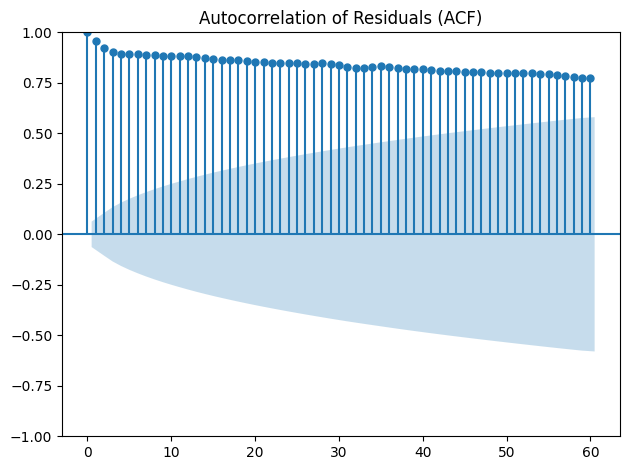

In [27]:
# Cell 7 - Additional diagnostics (optional). Requires scipy and statsmodels; these are optional.
# If you don't have these packages installed, skip this cell or pip install them.

try:
    from scipy.stats import shapiro
    from statsmodels.graphics.tsaplots import plot_acf

    residuals = (y_true.ravel() - y_pred.ravel())

    # Shapiro-Wilk test for normality (works for n <= 5000 reliably)
    stat, p_value = shapiro(residuals[:5000])  # limit to 5000 for speed/validity
    print("Shapiro-Wilk normality test (first 5000 residuals):")
    print(f" statistic = {stat:.6f}, p-value = {p_value:.6f}")
    if p_value < 0.05:
        print(" => Residuals likely NOT normal (p < 0.05).")
    else:
        print(" => Residuals are plausibly normal (p >= 0.05).")

    # Autocorrelation of residuals
    plt.figure(figsize=(10, 4))
    plot_acf(residuals, lags=60, alpha=0.05)
    plt.title("Autocorrelation of Residuals (ACF)")
    plt.tight_layout()
    plt.show()
except Exception as exc:
    print("Optional diagnostic skipped (scipy/statsmodels not installed):", exc)
    print("Install 'scipy' and 'statsmodels' to run additional diagnostics.")
